# Lab 6 - Quasi-experimental methods


## Introduction
---

The focus of this lab is two quasi-experimental methods for answering causal questions: regression discontinuity (RD) and differences in differences (DD). These are methods we can use when it is infeasible or impractical to run a true randomized experiment.

## Background: Yelp and Valuing Online Reputation
---

Consumer reviews play a prominent role in many markets. Review systems can create value for both buyers and sellers by providing information about products, particularly for products that are not already well-known. Review systems can also be ineffective if, for example, fraud is rampant or reviews are not very informative (e.g., every review is 5 stars).

Consider Yelp. The causal question we will answer is: for a restaurant, *how valuable is it to have a additional half-star rating?* Restaurants care about the answer because it informs how much they should invest in improving their ratings. Yelp cares about the value that its review system provides.

This is a causal question. We want to know how a restaurant's profitability would change if its rating were one half-star higher. Clearly, this is a question that is not well-suited to a randomized experiment. While techincally feasible, it would probably be a very bad idea to randomize the reviews a restaurant receives.

But there is still hope. We have quasi-experimental methods at our disposal.

## Table of Contents

1. [Regression Discontinuity](#rd) <br>
2. [Differences in Differences](#did) <br>

## 1. Regression Discontinuity <a id='rd'></a>

Here's an **interesting feature of Yelp:** Average restaurant ratings are measured continuously from 0 to 5. 

- Yet consumers see stars rounded to the half-star level!

**Implication:** There are **sharp thresholds** that cause restaurants to be classified in different ways:

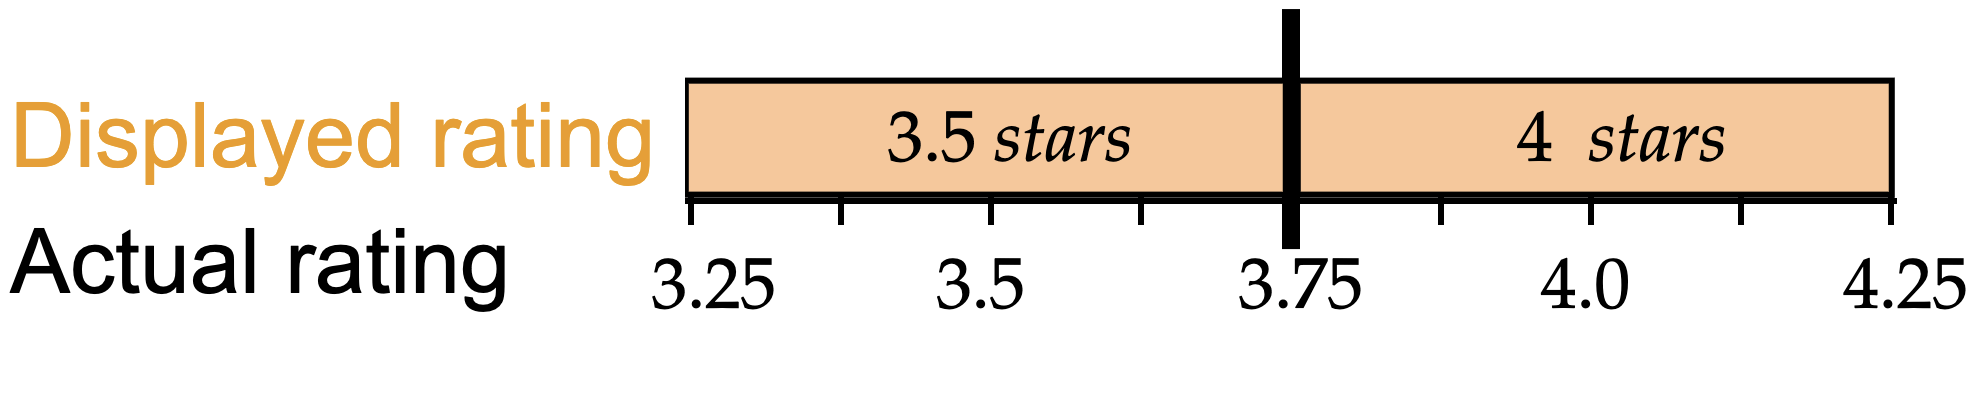

Here our **sharp threshold** occurs at 3.75. 

- (3.25 to 3.75] star **average ratings** are **displayed as** 3.5 stars.

- (3.75 to 4.25] star **average ratings** are **displayed as** 4 stars.

An arbitrarily small change in rating around the 3.75 threshold is displayed to consumers as a shift from 3.5 to 4 stars!

### 1.1. From thresholds to causal effects

Here's the idea behind **regresion discontinuity**:

- Think about restaurants just below or just above a threshold.

- These restaurants are probably similar. 

- E.g., Imagine comparing resturants with an average rating of:
      - 3.74999999999....9 (displayed as 3.5 stars)
      - 3.7500000000....1 (displayed as 3.5 stars)
- These restaurants have (almost) identical quality.

&#x2192; We can (often) interpret the difference in outcomes between these two groups **as the causal effect of the intervention** (in this case, a half-star hring rating).

**More generally, regression discontinuity:**

- Is a useul method in any situation where a "cutoff" is used to assign treatment. 
- Intuitively, one compares outcomes for individuals just above the cutoff to outcomes for individuals just below. 

### 1.2 Yelp data

We will work with two data sets that are merged together. The first data set is the full history of reviews for each San Francisco restaurant on Yelp.com as of February 2011. The data include the average rating and total number of reviews for each restaurant at every point in time.

These data are combined with reservation availability data from a large online
reservation website (think Open Table, Resy, etc.), which lists real-time reservation availability for a subset of the restaurants in the Yelp data. From July 21st to October 29th 2010, the data includes reservation availability for a party of four on Thursday, Friday and Saturday evenings at 7pm and 8pm. Availability is measured approximately 36 hours prior to the time of the desired reservation.

The dataset includes the following variables:

**Running variable (which defines treatment):** 

* `avg_rating`: the average restaurant rating from 0 to 5.

**Treatment:** 

- `display_rating`: The restaurants **displayed** rating (using rounded 0.5 star increments).

**Outcomes:**
- `avail_7pm`: The **average** availability of a restaurant at 7pm.
- `avail_8pm`: The **average** availability of a restaurant at 8pm.

**More** availabilities mean the restaurant has **less** customers.


**Other variables:**

* `price`: price category of restaurant ($ \$, \; \$\$, \; \$ \$ \$, \; \$ \$ \$ \$ $)

* `restaurant`: name of the restaurant

* `neighborhood`: name of the SF neighborhood where the restaurant is located

* `yelp_category`: Cuisine type


In the lab we will **focus our analysis on restaurants receiving ratings between 3.25 and 4.25**. Remember:

- (3.25 to 3.75] star **average ratings** are **displayed as** 3.5 stars.

- (3.75 to 4.25] star **average ratings** are **displayed as** 4 stars.

We can think of our *treatment* as whether the restaurant received 4 stars (rather than 3.5 stars). 


Let's look at our data and treatment assignment:

In [ ]:
#load libraries

library(dplyr)
library(ggplot2)

In [ ]:
# Load the data (limiting  to restaurants with average ratings between 3.25 and 4.25)

Yelp <- read.csv("YelpRD.csv") %>%
    filter(avg_rating >= 3.25 & avg_rating <= 4.25)

head(Yelp)

To begin, let's plot the relationship between `avg_rating` and `display_rating`.

In [ ]:
#Create a figure to check where there is discrete break in treatment
ggplot(Yelp, aes(x = avg_rating, y = display_rating, color = display_rating)) +
  # Make points small and semi-transparent since there are lots of them
  geom_point(size = 0.5, alpha = 0.5) + 
  geom_vline(xintercept = 3.75, color="red") +  # This is our threshold
  # Add labels
  labs(x = "Average rating", y = "Display rating") +theme_classic() + theme(legend.position = "none")

*How do you interpret this figure?*

### 1.4 Notation and variable creation

We refer to the variable defining our treatment as the *running variable*.

- Our running variable is `avg_rating`.

**Threshold**: Our **threshold** or **cutoff** is 3.75.

We can define a variable for crossing the threshold, `cross`:
    
$\text{cross}_i=\begin{cases}
      0~(\text{i.e., 3.5 star}), & \text{if}\ Rating < 3.75  \\
      1~(\text{i.e., 4 star}), & \text{if}\  Rating \ge 3.75 
    \end{cases}$

In [ ]:
#create variable for treatment (crossing threshold)

Yelp <- Yelp %>%
    mutate(cross = ifelse(..., 1, 0))

head(Yelp)

### 1.5 Manipulation

**Concern**: If there is a  benefit to receiving a treatment, people (or restaurants) could manipulate their score to be **just above** the threshold.

What would the problem be if restaurants were able to manipulate their scores around this threshold?

- There would be a big stack of restuarants just above the threshold!
- Which restaurants would be just below 3.75? Perhaps the restaurants that were not motivated.
- That would distort our estimates by creating imbalance between restaurants on either side of the threshold.

**Fortunately**: people (firms, etc) often are not able to manipulate things precisely.
- There will still be random variation right around the treatment threshold, so that units on either side are very similar.

We can check for manipulation by running a **balance check** comparing those above and below the threshold.

- This tells us whether there are systematic differences in (for example) the attributes of restaurants just above or below our threshold.

Let's check whether it looks like experimental groups differ on `price` (e.g., how expensive the restaurant is) around the threshold:


In [ ]:
# check for balance on price (this will take a moment to run)
ggplot(Yelp, aes(x = avg_rating, y = price)) +
  geom_smooth(method=loess) + theme_classic()+ 
  labs(x = "Average rating", y = "Price") + 
  geom_vline(xintercept = 3.75, color="red")  # This is our threshold

*How does it look?*

### 1.6 Estimating the causal effect

Finally, let's use our regression discontinuity to estimate a causal effect (visually) on our outcome : 

- `avail_7pm`: The **average** availability of a restaurant at 7pm.

In [ ]:
# Testing results

ggplot() +
  ylim(0, 1) + 
  # Add a line based on a linear model for the restaurants with ratings weakly below 3.75
  geom_smooth(aes(x = avg_rating, y = avail_7pm), color = "blue", data = filter(Yelp, avg_rating <= 3.75), method = "lm", se = FALSE) +
  # Add a line based on a linear model for the restaurants with ratings above 3.75
  geom_smooth(aes(x = avg_rating, y = avail_7pm), color = "black", data = filter(Yelp, avg_rating > 3.75), method = "lm" , se = FALSE) +
  geom_vline(xintercept = 3.75, color="red") +
  labs(x = "Average rating", y = "Probability of having availability at 7pm") +theme_classic() + theme(legend.position = "none")

Note: The more likely the restaurant is to have an availability, the less customers it has.

- What is our causal effect? It is the vertical distance between the black line on the left and the blue line.

We can represent this in regression form as:

$$\text{avail}\_\text{7pm}_{i} = \beta_{0} + \beta_{1} \text{cross}_{i} + \beta_{2} (\text{avg}\_\text{rating}_{i} - 3.75) + \beta_{3} (\text{avg}\_\text{rating}_{i} - 3.75) \times \text{cross}_{i}   + e_{i}$$

- Where $\beta_{1}$ captures the estimated causal effect (the vertical distance between the two lines at the threshold).

We will first create a new variable `avg_rating_adj` = `avg_rating` - 3.75.

In [ ]:
#create new variable that is re-centered version of `avg_rating` ((`avg_rating` - 3.75))
Yelp <- Yelp %>%
    mutate(avg_rating_adj = ...)


Next we will estimate the regression model written out above.

<span style="color:red">**Note:** </span> to include an interaction term (e.g., `var1` $\times$ `var2`) in a regression model, you can just write `var1`*`var2` in the `lm` function.

In [ ]:
# Estimate RD model
model_baseline <- lm(...)

summary(model_baseline)


*What does your estimate imply?*

### 1.7 Bandwidth

But wait...

- A restaurant with a rating of 3.25 is much worse than one with a rating of 4.25!

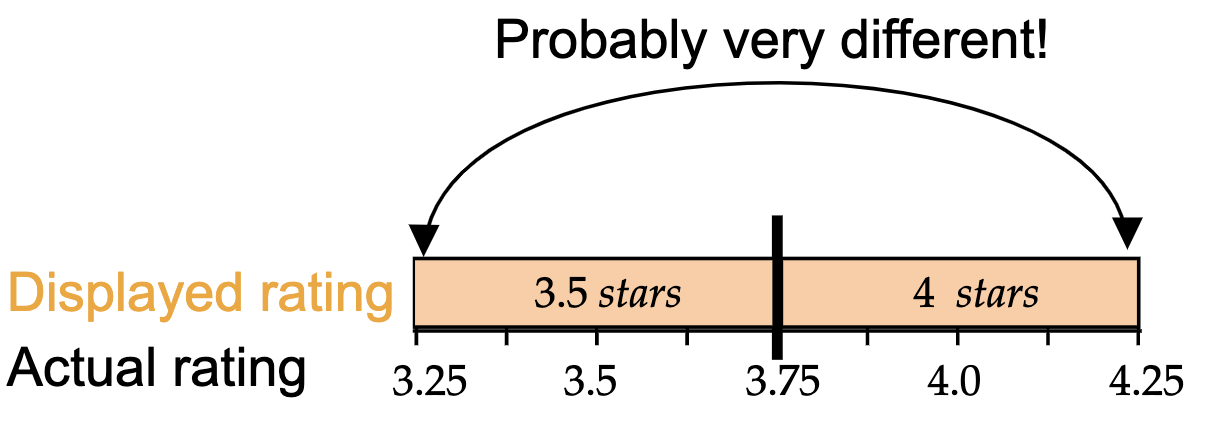

Our restaurants are (probably) more similar as we get arbitrarily close to 3.75 from above and below.

- Tradeoff: if we just looked at restaurants right below and right above the threshold, we would have only a few observations!

We will test several different **bandwidths** around our RD threshold of 3.75. By bandwidths we mean different windows of data around the threshold. You've already look at restaurants with `avg_rating` within within $\pm 0.5$ of 3.75 (3.25 to 4.25).

Let's try two alternative bandwidths:
  - `avg_rating` is within $\pm 0.4$ of 3.75: 3.35 to 4.15
  - `avg_rating` is within $\pm 0.2$ of 3.75: .55 to 3.95

In each model we **throw out** the observations outside our bandwidth.


In [ ]:
# Model with bandwidth 3.35-4.15
model_bw1 <- lm(...,
                   data = Yelp %>% filter(...))

# Model with bandwidth 3.55-3.95
model_bw2 <- lm(...,
                   data = Yelp %>% filter(...))

summary(model_bw1)
summary(model_bw2)

I've summarized results in a table:

| Bandwidth  | Estimated treatment effect |
| -----------| --------                   |
| 0.5        | -0.2125                    |
| 0.4        | -0.1647                    |
| 0.2        | -0.1500                    |

**Which one is right?** We don't know. But the smaller bandwidths still produce meaningful differences.

For example, at a relatively tight bandwidth of 0.2 our treatment effect is -0.15. 

In other words, the effect of an additional 0.5 stars is **a 15 percentage point reduction in treatment restaurants having availabilities at 7pm.** (Pretty big!)


### 1.8 Summary


- **What.** Regression discontinuity designs leverage sharp thresholds in assignment to treatment.

- **How.** Our strategy to identify the causal effect of the treatment is based on the idea that people are similar around the threshold.

- **Robustness.** We should test to see:

  - If it looks like people are self-selecting to be on side of the threshold or the other (bad!)
  
  - We should test the difference in estimates using different bandwidths.

## 2. Differences in Differences (DD) <a id='did'></a>

So far: RD - Can often generate convincing evidence on the causal effect of the treatment.

**But:**

- Causal effects are limited to those around the threshold.

- Need to have a threshold! Fairly restrictive.


### 2.1 Setup


**Difference in difference** designs leverage two sources of variation:
 
 - Changes over time (first difference).
 - Policy change that occurs in some units but not others (second difference).

**Comparison to RD**: Less restrictive requirements - just need to observe groups over time when the policy change took place.

**Challenge**: Need to convince people that the **only relevant difference** between groups is the policy change.

Formally, this is called the **parallel trends assumption**: we assume that our "treatment" and "control" groups are on the same trajectory up to the point that the policy was implemented. 

Note: even if groups *look to be on the same trajectory*, that doesn't rule out confounding!


### 2.2 Data

We're going to use a modified version of the last dataset, with a **hypothetical** policy change:

- Certain areas of the Bay *ban* Yelp (areas are indexed by `LocationGroup`).

Our data has 3 time periods, defined by `time`.
- Periods 1 and 2 were before the policy was implemented.
- In Period 3, areas with `PolicyGroup`=1 experienced a *ban* in Yelp reviews (note: `PolicyGroup`=1 for these areas even before the change).

`PrePost` is a variable taking a value 1 for Period 3, and 0 for Periods 1 and 2.

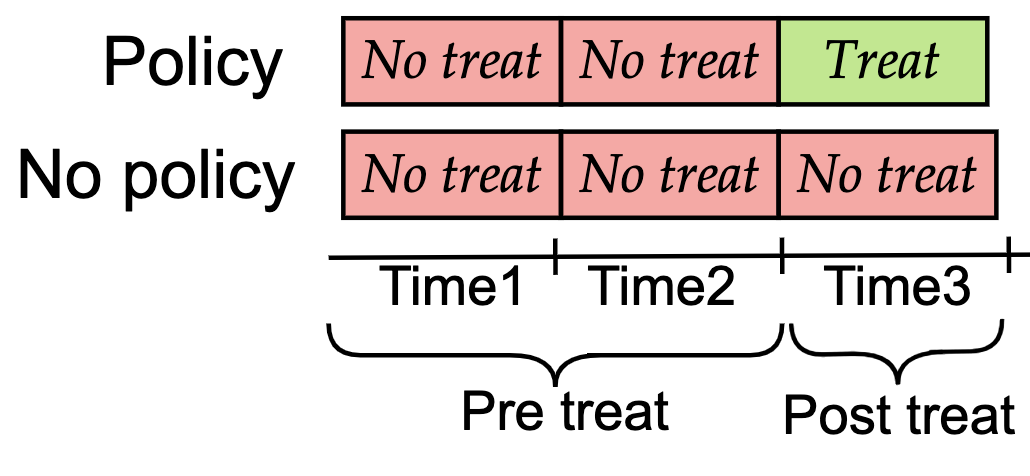

**Outcomes:**
- `Avail_7pm_LowRating`: The availability of **low-rated** restaurants at 7pm (for a random day), where 1=has availabilities.
- `Avail_7pm_HighRating`:  The availability of **highly-rated** restaurants at 7pm (for a random day), where 1=has availabilities.

- Note that we still refer to a restaurant as low- or high-rated after a ban has been implemented.

**More** availabilities mean the restaurant has **less** customers.

Let's look at the data:

In [ ]:
YelpDID <- read.csv("YelpDID.csv")

head(YelpDID)

Note that our data here are in **long** format: we observe restaurants in different time periods stacked on top of each other.

**Key assumption**: Our key assumption is that the treated and untreated areas were on the same trajectory before the Yelp ban was implemented.

- Let's examine this by plotting the average values of the outcome we will focus on in this lab (`Avail_7pm_LowRating`) by time period.

In [ ]:
#This code calculates averages by "time" and "PolicyGroup"
meanDID <- YelpDID %>%
    select(time, PolicyGroup, Avail_7pm_LowRating) %>%
    group_by(PolicyGroup, time) %>%
    summarize(Avail_7pm_LowRating = mean(Avail_7pm_LowRating))

meanDID

Now let's plot our results.

In [ ]:
ggplot(meanDID,aes(x = time, y = Avail_7pm_LowRating,color=as.factor(PolicyGroup),group=as.factor(PolicyGroup))) + 
  geom_line()+  xlab('Period (month)') +theme_classic() +  geom_vline(xintercept = 2, color="black") +ylab("Availability of Low-Rated Restaurants")


We see that the trajectory looks similar until month 2 when the policy is implemented.

- But we may have examples where there is, for example, an increasing trend over time, or seasonal changes. 

**The key thing to assess is that the distance between the two lines is relatively constant over time (pre-treatment).**

### 2.3. Treatment effects with DD

It's often helpful to think of difference in difference in 4 cases:
- Pre-policy (no treatment)
- Post-policy (no treatment)
- Pre-policy (treated)
- Post-policy (treated)

Let's calculate the mean for each case:

In [ ]:
YelpDID %>%
    group_by(PolicyGroup, PrePost) %>%
    summarize(Avail_7pm_LowRating = mean(Avail_7pm_LowRating))

Here I've filled in the mean outcome for each part. 


| 		             |Pre-policy   |Post-policy   |
| -----------        |-----------  | -----------  |
| **No policy**      | (a) 0.709   | (b) 0.690    |
| **Received policy**| (c) 0.692   | (d) 0.324    |

The only cell where individuals receive the policy is the bottom right cell **Received policy *and* Post-policy**.


#### 2.3.1. "Manual" diffference in differene estimates

For intuition, let's calculate our difference in difference treatment effect "manually".

First let's calculate change over time between the two groups:
 - Change over time for the group that didn't receive the policy is: $~~~~b-a=0.69-0.709=-0.019$
 - Change over time for the group that received the policy is:       $~~~~~~~~~~~d-c=0.324-0.69=-0.368$

Now let's calculate the difference between these difference:

(Time change if had policy)-(Time change if didn't have policy)= $-0.368-(-0.019)=-0.349$

**Interpretation:** Our **difference in difference estimate** of the causal effect of the policy (treatment effect) is that it decreased low-rated restaurant availability by 0.349 (or 34.9 percentage points - which is a good thing for those restaurants!)


#### 2.3.2. DD regression estimates

Finally, let's transition to regression:

We run a regression with the following as explanatory variables: 
- an indicator variable that takes a value of 1 for "post intervention" (PrePost).
- an indicator for treatment group that takes a value of 1 if the group received the intervention (PolicyGroup).
- and an indicator that is the **interaction** of the two variables above (PolicyGroup*PrePost).
  - This variable takes a value of 1 if we are both post intervention and in the group receiving the policy (PolicyGroup=1).
  
The coefficient on the interaction term (PolicyGroup*PrePost) tells us the treatment effect.

In [ ]:
DID_model <-

summary(DID_model)

**Interpretation:** The difference in difference *regression* tells us the same thing our "manual" calculation did: that availabilities decreased by 0.349 among low-rated restaurants after the policy change.

But now we can see that this effect is highly significant!